In [ ]:
#conncet to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# switch to working path
import os
repo_name = "hurricane-harm-herald"
target_dir = "/content/drive/MyDrive/ai4er/python/hurricane"
os.chdir(target_dir)
print(os.getcwd())

/content/drive/MyDrive/ai4er/python/hurricane


In [ ]:
%cd /content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/notebooks

/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/notebooks


In [ ]:
#install required packs
!pip install rasterio 
!pip install richdem
!pip install geopandas
!pip install vptree geographiclib
!pip install cartopy
#!pip install pandas==1.4.1
!pip install pandas==1.5.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 75.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 KB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for richdem: filename=richdem-0.3.4-cp38-cp38-linux_x86_64.whl size=7997016 sha256=3a5fd95f8e7d653b9dae5d5cfafe09e8331c4929756a60ef0ee9b4e21360c6db
  Stored in directory: /root/.cache/pip/wheels/9f/9c/61/8da642da1b65cbf887fa5d335778dfcefe22fba629e6b055d4
Successfully built richdem
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# import packages
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import richdem as rd
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import pickle
import vptree
from geographiclib.geodesic import Geodesic
import cartopy.crs as ccrs
import math
import zipfile
from affine import Affine
import shapefile 
import cartopy.feature as cfeature

In [ ]:
#load the data of the locations (lon, lat) of buildings
building_locs_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/metadata_pickle/lnglat_pre_pol_post_damage.pkl'
#building_locs_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/xBD_data/xbd_points_posthurr_reformatted.pkl'
with open(building_locs_path, 'rb') as f:
    building_locs = pd.read_pickle(f)

In [ ]:
building_locs

,geometry,polygon_lnglat,point_xy,polygon_xy,disaster_name,image_name,capture_date,match_num,damage_class
0,POINT (-85.67391 30.20724),"POLYGON ((-85.6738930594241 30.20719684096294,...",POINT (1020.333333333333 310.7372593561061),"POLYGON ((1024 321.3965635828249, 1024 300.49,...",hurricane-michael,hurricane-michael_00000401_pre_disaster.png,2017-10-05 16:51:27+00:00,0,2
1,POINT (-85.67434 30.20753),POLYGON ((-85.67449692453123 30.20766202266222...,POINT (931.694750943659 243.3784985829341),"POLYGON ((897.9496371913862 212.1958885875354,...",hurricane-michael,hurricane-michael_00000401_pre_disaster.png,2017-10-05 16:51:27+00:00,1,0
2,POINT (-85.67391 30.20767),POLYGON ((-85.67388574202296 30.20774252122654...,POINT (1019.501848872749 209.0688284839606),"POLYGON ((1024 191.5771820858756, 1015.5814922...",hurricane-michael,hurricane-michael_00000401_pre_disaster.png,2017-10-05 16:51:27+00:00,2,0
3,POINT (-85.67392 30.20754),POLYGON ((-85.67388810138917 30.20756657794196...,POINT (1016.885605126621 239.1370304435527),"POLYGON ((1024 233.4347506531545, 1009.7193348...",hurricane-michael,hurricane-michael_00000401_pre_disaster.png,2017-10-05 16:51:27+00:00,3,0
4,POINT (-85.67392 30.20749),POLYGON ((-85.67388934178517 30.20747407817671...,POINT (1017.83517631675 252.35283473389),"POLYGON ((1024 255.440791938119, 1020.99390303...",hurricane-michael,hurricane-michael_00000401_pre_disaster.png,2017-10-05 16:51:27+00:00,4,0
...,...,...,...,...,...,...,...,...,...
23049,POINT (-85.67911 30.11550),"POLYGON ((-85.6791135278477 30.11555096340542,...",POINT (981.1100299145855 212.7921362790846),"POLYGON ((981.0440671503468 200.7252030371058,...",hurricane-michael,hurricane-michael_00000376_pre_disaster.png,2017-10-05 16:51:27+00:00,2,0
23050,POINT (-85.67895 30.11545),POLYGON ((-85.67890615427049 30.11551911018989...,POINT (1014.557959734563 224.7234903327919),"POLYGON ((1024 207.8032533465117, 1014.8614186...",hurricane-michael,hurricane-michael_00000376_pre_disaster.png,2017-10-05 16:51:27+00:00,3,1
23051,POINT (-85.67950 30.11408),POLYGON ((-85.67952856687066 30.11421539867797...,POINT (904.4149664871511 550.3481142071457),"POLYGON ((898.9199586913538 519.2875128239389,...",hurricane-michael,hurricane-michael_00000376_pre_disaster.png,2017-10-05 16:51:27+00:00,4,1
23052,POINT (-85.67937 30.11381),POLYGON ((-85.67938356175726 30.11391203148795...,POINT (932.8153744233234 614.1249757214571),"POLYGON ((929.7301677191299 591.0752998586572,...",hurricane-michael,hurricane-michael_00000376_pre_disaster.png,2017-10-05 16:51:27+00:00,5,2


In [ ]:
building_locs.columns

Index(['geometry', 'polygon_lnglat', 'point_xy', 'polygon_xy', 'disaster_name',
       'image_name', 'capture_date', 'match_num', 'damage_class'],
      dtype='object')

In [ ]:
building_locs=pd.DataFrame({'lat':building_locs['geometry'].y,'lon':building_locs['geometry'].x ,'disaster_name':building_locs['disaster_name'],'damage_class':building_locs['damage_class']})
#building_locs['lat'],building_locs['lon']=building_locs['geometry'].y,building_locs['geometry'].x 

#divide the building locations into groups that cover 1 degree latitude and longitude
lon_bins = pd.cut(building_locs['lon'], bins=range(-180, 181, 1))
lat_bins = pd.cut(building_locs['lat'], bins=range(-90, 91, 1))

building_groups = building_locs.groupby([lon_bins, lat_bins])

In [ ]:
# check the data
building_locs

,lat,lon,disaster_name,damage_class
0,30.207242,-85.673910,hurricane-michael,2
1,30.207529,-85.674335,hurricane-michael,0
2,30.207669,-85.673908,hurricane-michael,0
3,30.207543,-85.673923,hurricane-michael,0
4,30.207487,-85.673919,hurricane-michael,0
...,...,...,...,...
23049,30.115500,-85.679114,hurricane-michael,0
23050,30.115448,-85.678953,hurricane-michael,1
23051,30.114085,-85.679504,hurricane-michael,1
23052,30.113815,-85.679370,hurricane-michael,2


/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


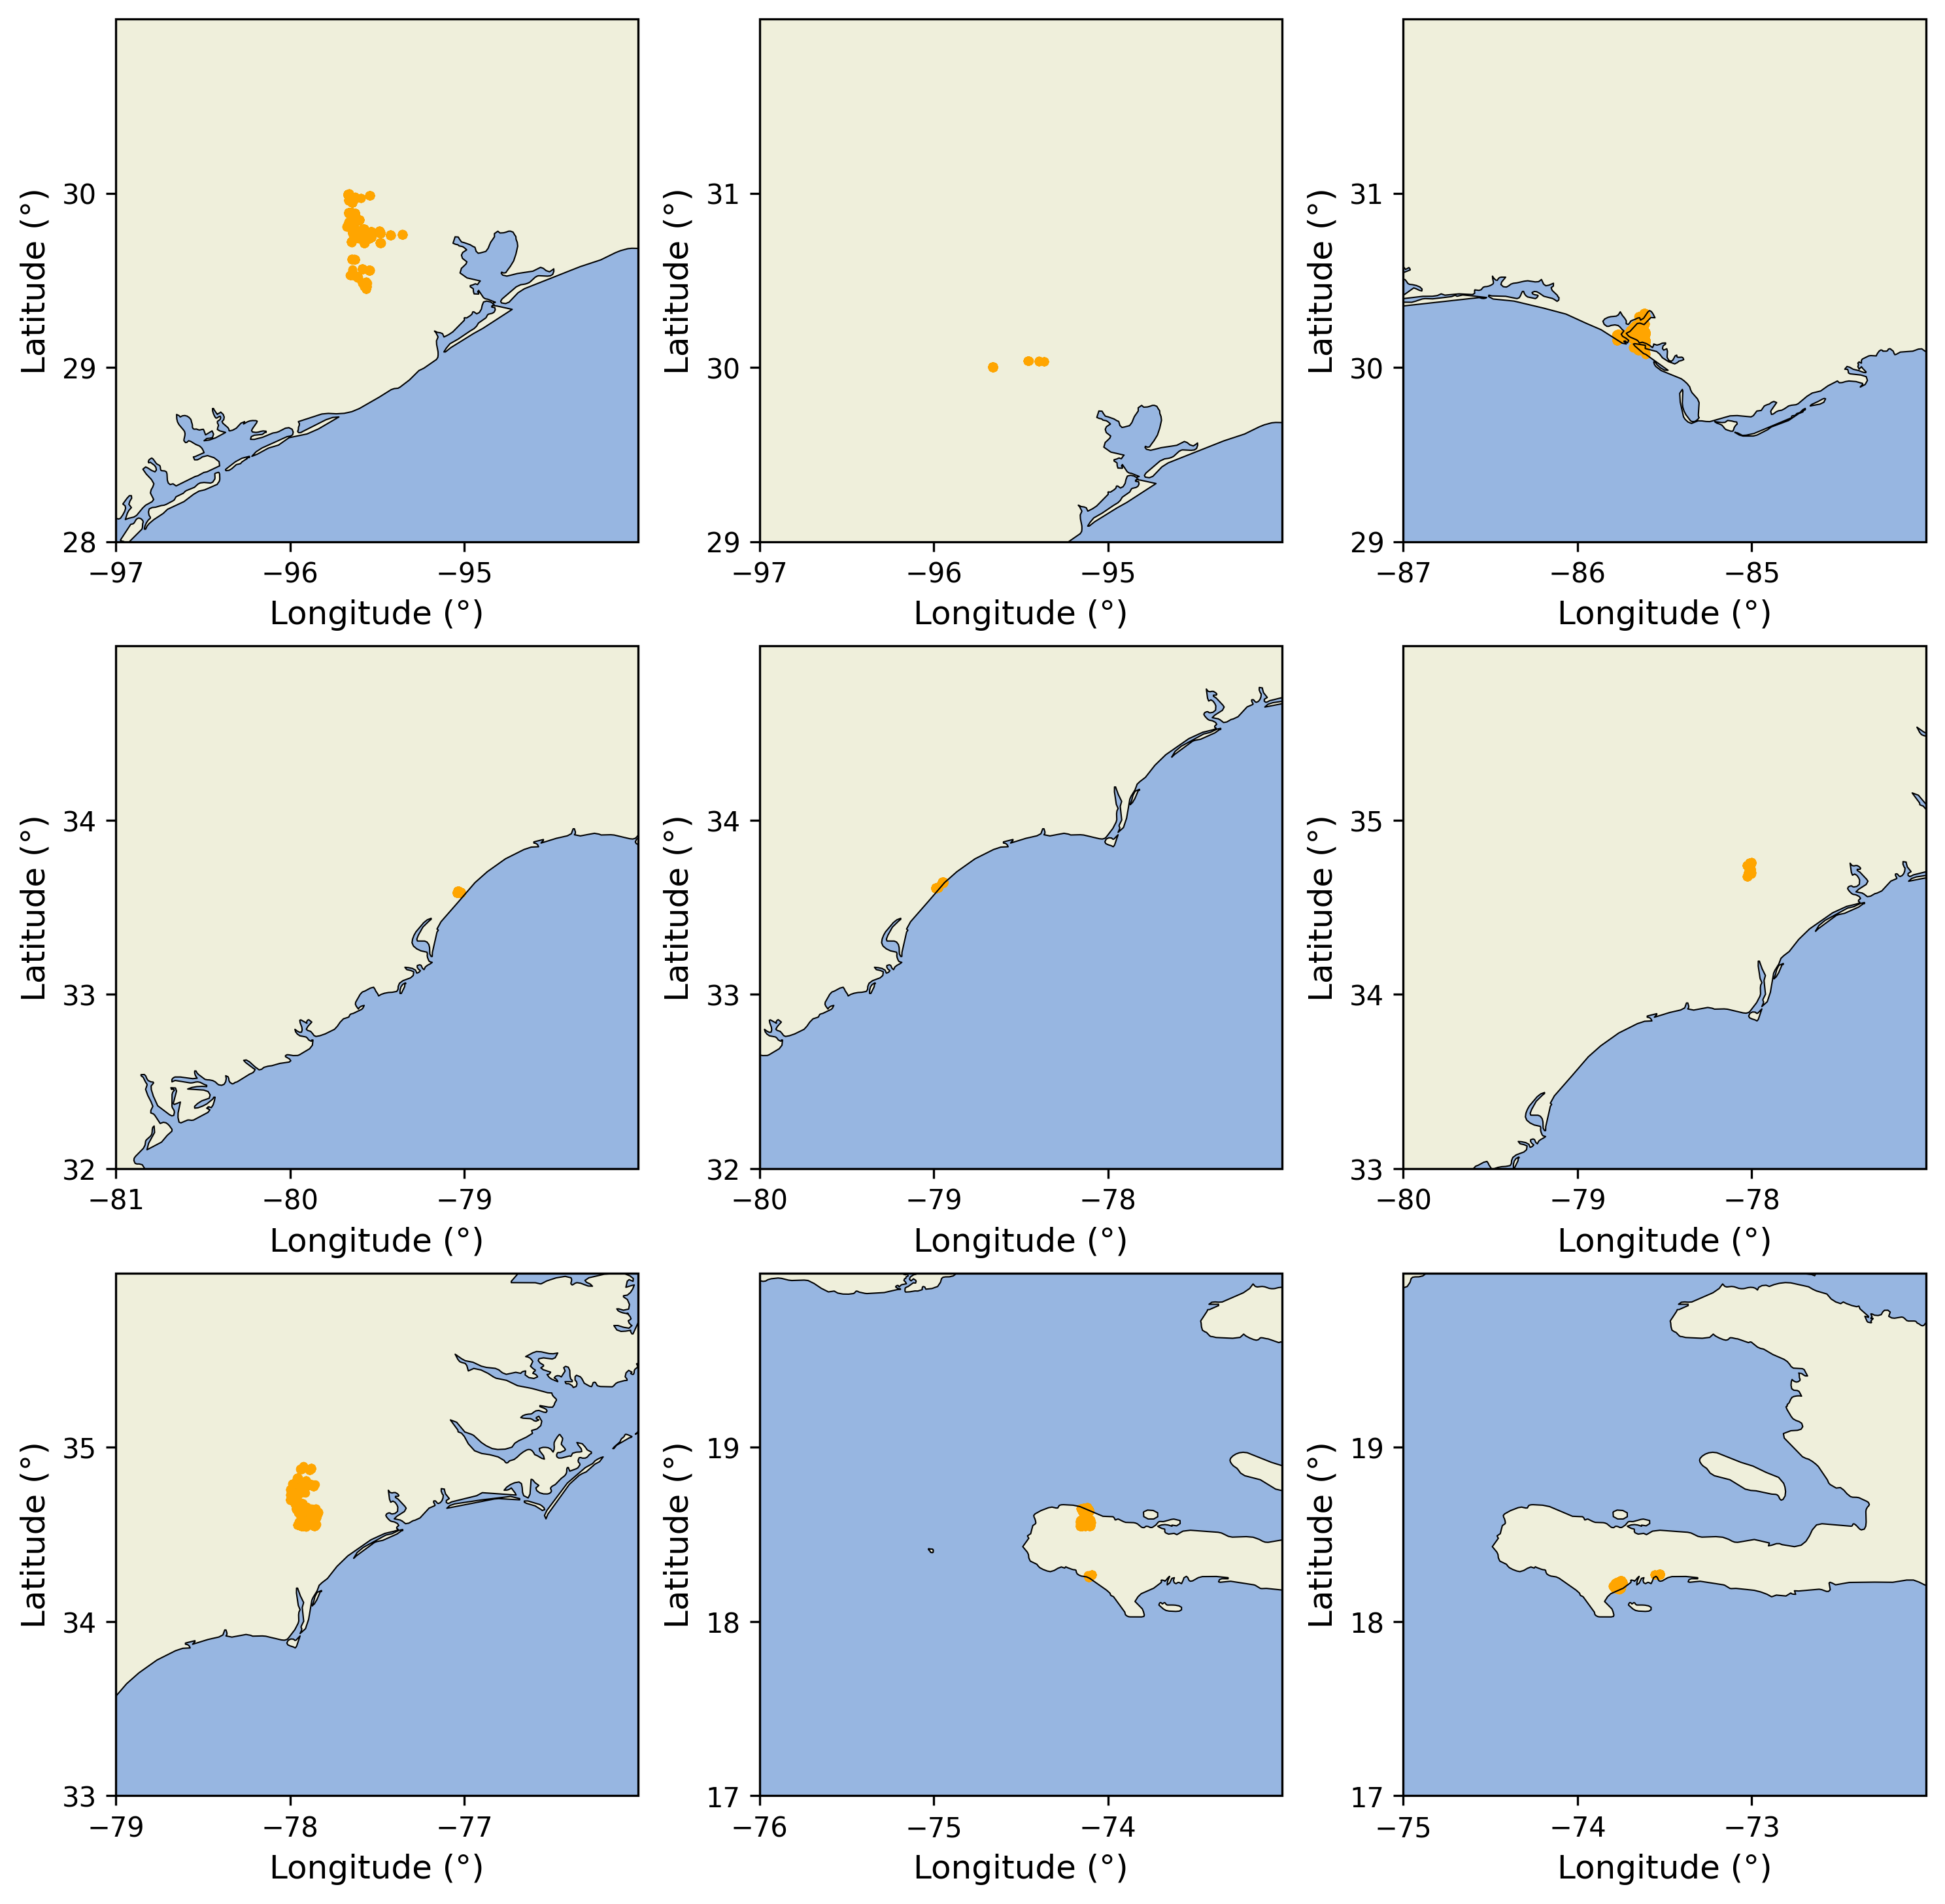

In [ ]:
#plot the building locations for verification
n_groups = len(building_groups) #group number
n_cols=3                        #column number
n_rows = math.ceil(n_groups / n_cols)   # raw number
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12),dpi=300,
                        subplot_kw={'projection': ccrs.PlateCarree()})

for i, (group_name, group_data) in enumerate(building_groups):
    west=int(np.floor(group_data['lon'].min()))
    east=int(np.ceil(group_data['lon'].max()))
    south=int(np.floor(group_data['lat'].min()))
    north=int(np.ceil(group_data['lat'].max()))
    dis_threshold=1
    # plot the buildings and the coastline data that been choped
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    ax.set_xlim(west-dis_threshold, east+dis_threshold)
    ax.set_ylim(south-dis_threshold, north+dis_threshold)

    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))
    #plot the locations of buildings
    ax.scatter(group_data['lon'], group_data['lat'], s=5, transform=ccrs.PlateCarree(),c='orange')
    # Set x-label and y-label
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    # Set x-ticks and y-ticks
    xticks = np.arange(west-dis_threshold, east+dis_threshold, dis_threshold)
    yticks = np.arange(south-dis_threshold, north+dis_threshold, dis_threshold)

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

while i < n_cols*n_rows-1:
    fig.delaxes(axs.flatten()[i+1])
    i += 1
plt.show()

In [ ]:
# This cell check whether coastline data has been downloaded
# You can download coastline data from Nature Earth (https://www.naturalearthdata.com/downloads/10m-physical-vectors/),
# and store the .zip coastline data to 'zip_path' (please change it according to your setting)

url='https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_coastline.zip'
zip_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/ne_10m_coastline.zip'
shp_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/ne_10m_coastline/ne_10m_coastline.shp'
coast_extracted_floder='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/ne_10m_coastline/'
pkl_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/ne_10m_coastline/ne_10m_coastline.pkl'

# check whether the .shp or .zip coastline data exist
if os.path.isfile(shp_path):
  print('.shp coastline file found')
else:
  if os.path.isfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(coast_extracted_floder) # the coastline data is in 10m resolution
  else:
    print('.zip coastline file not found, please download it from ',url,' manually') 


.shp coastline file found


In [ ]:
# Load the .shp coastline data
# Convert the .shp coast line data into points and store in a dataframe
shapefile = gpd.read_file(shp_path) # Read the shapefile
coast_points = pd.DataFrame(columns=['coast_lon', 'coast_lat'])  # Initialize the coast_points DataFrame
temp_array = []  # Initialize the temp_array as a list
for i, row in shapefile.iterrows():
    if row['geometry'].geom_type == 'LineString':
        for point in row['geometry'].coords:
            x, y = point
            p = [x, y]  # Create a list with two elements
            temp_array.append(p)  # Append the point to the list
        temp_df = pd.DataFrame(temp_array, columns=['coast_lon', 'coast_lat'])  # Create a DataFrame from the temp_array
        coast_points = pd.concat([coast_points, temp_df], ignore_index=True)  # Append the temp_df to the coast_points DataFrame
        temp_array = []  # Reset the temp_array to an empty list

coast_points     

,coast_lon,coast_lat
0,59.916026,-67.400486
1,59.678559,-67.394138
2,59.657481,-67.397231
3,59.646251,-67.406183
4,59.648123,-67.415948
...,...,...
410952,-0.004789,-0.004390
410953,-0.004789,0.004817
410954,0.004328,0.004817
410955,0.004328,-0.004390


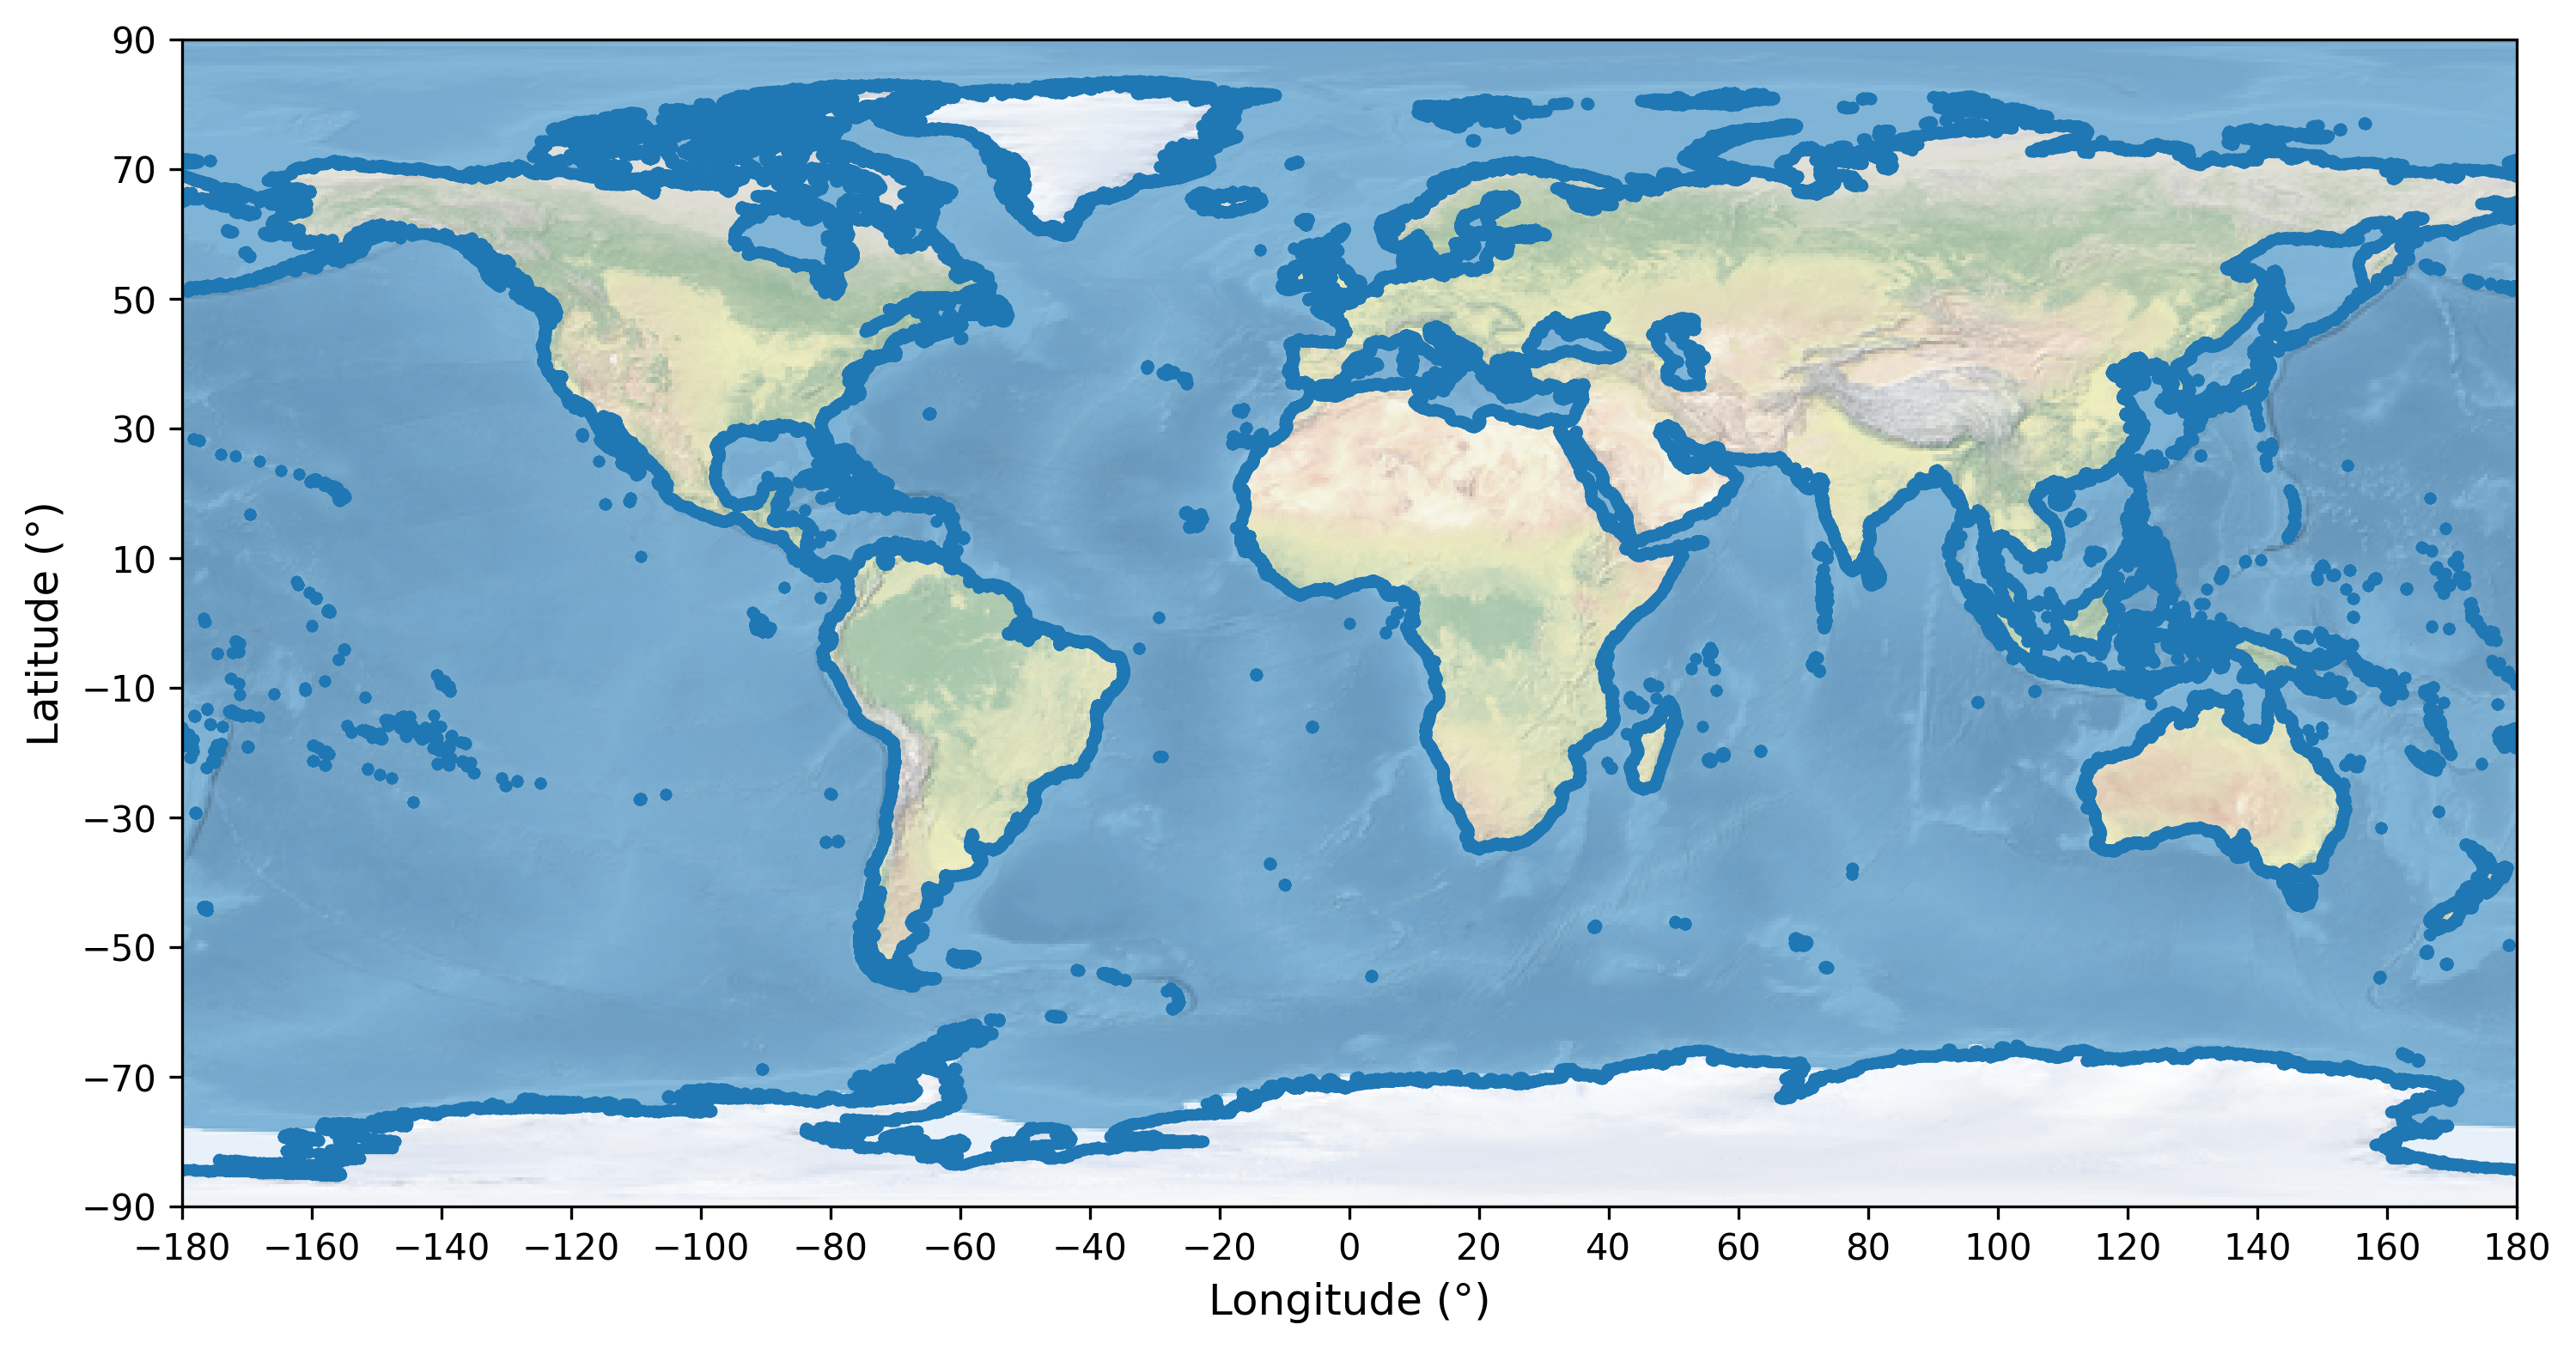

In [ ]:
# Plot the coastline data for verification

fig = plt.figure(figsize=(12, 6),dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Add a global map background
ax.stock_img()
# Plot the coast points
ax.scatter(coast_points['coast_lon'], coast_points['coast_lat'], s=5, transform=ccrs.PlateCarree())
# Set x-label and y-label
ax.set_xlabel('Longitude (°)', fontsize=12)
ax.set_ylabel('Latitude (°)', fontsize=12)
# Set x-ticks and y-ticks
xticks = np.arange(-180, 190, 20)
yticks = np.arange(-90, 100, 20)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

plt.show()


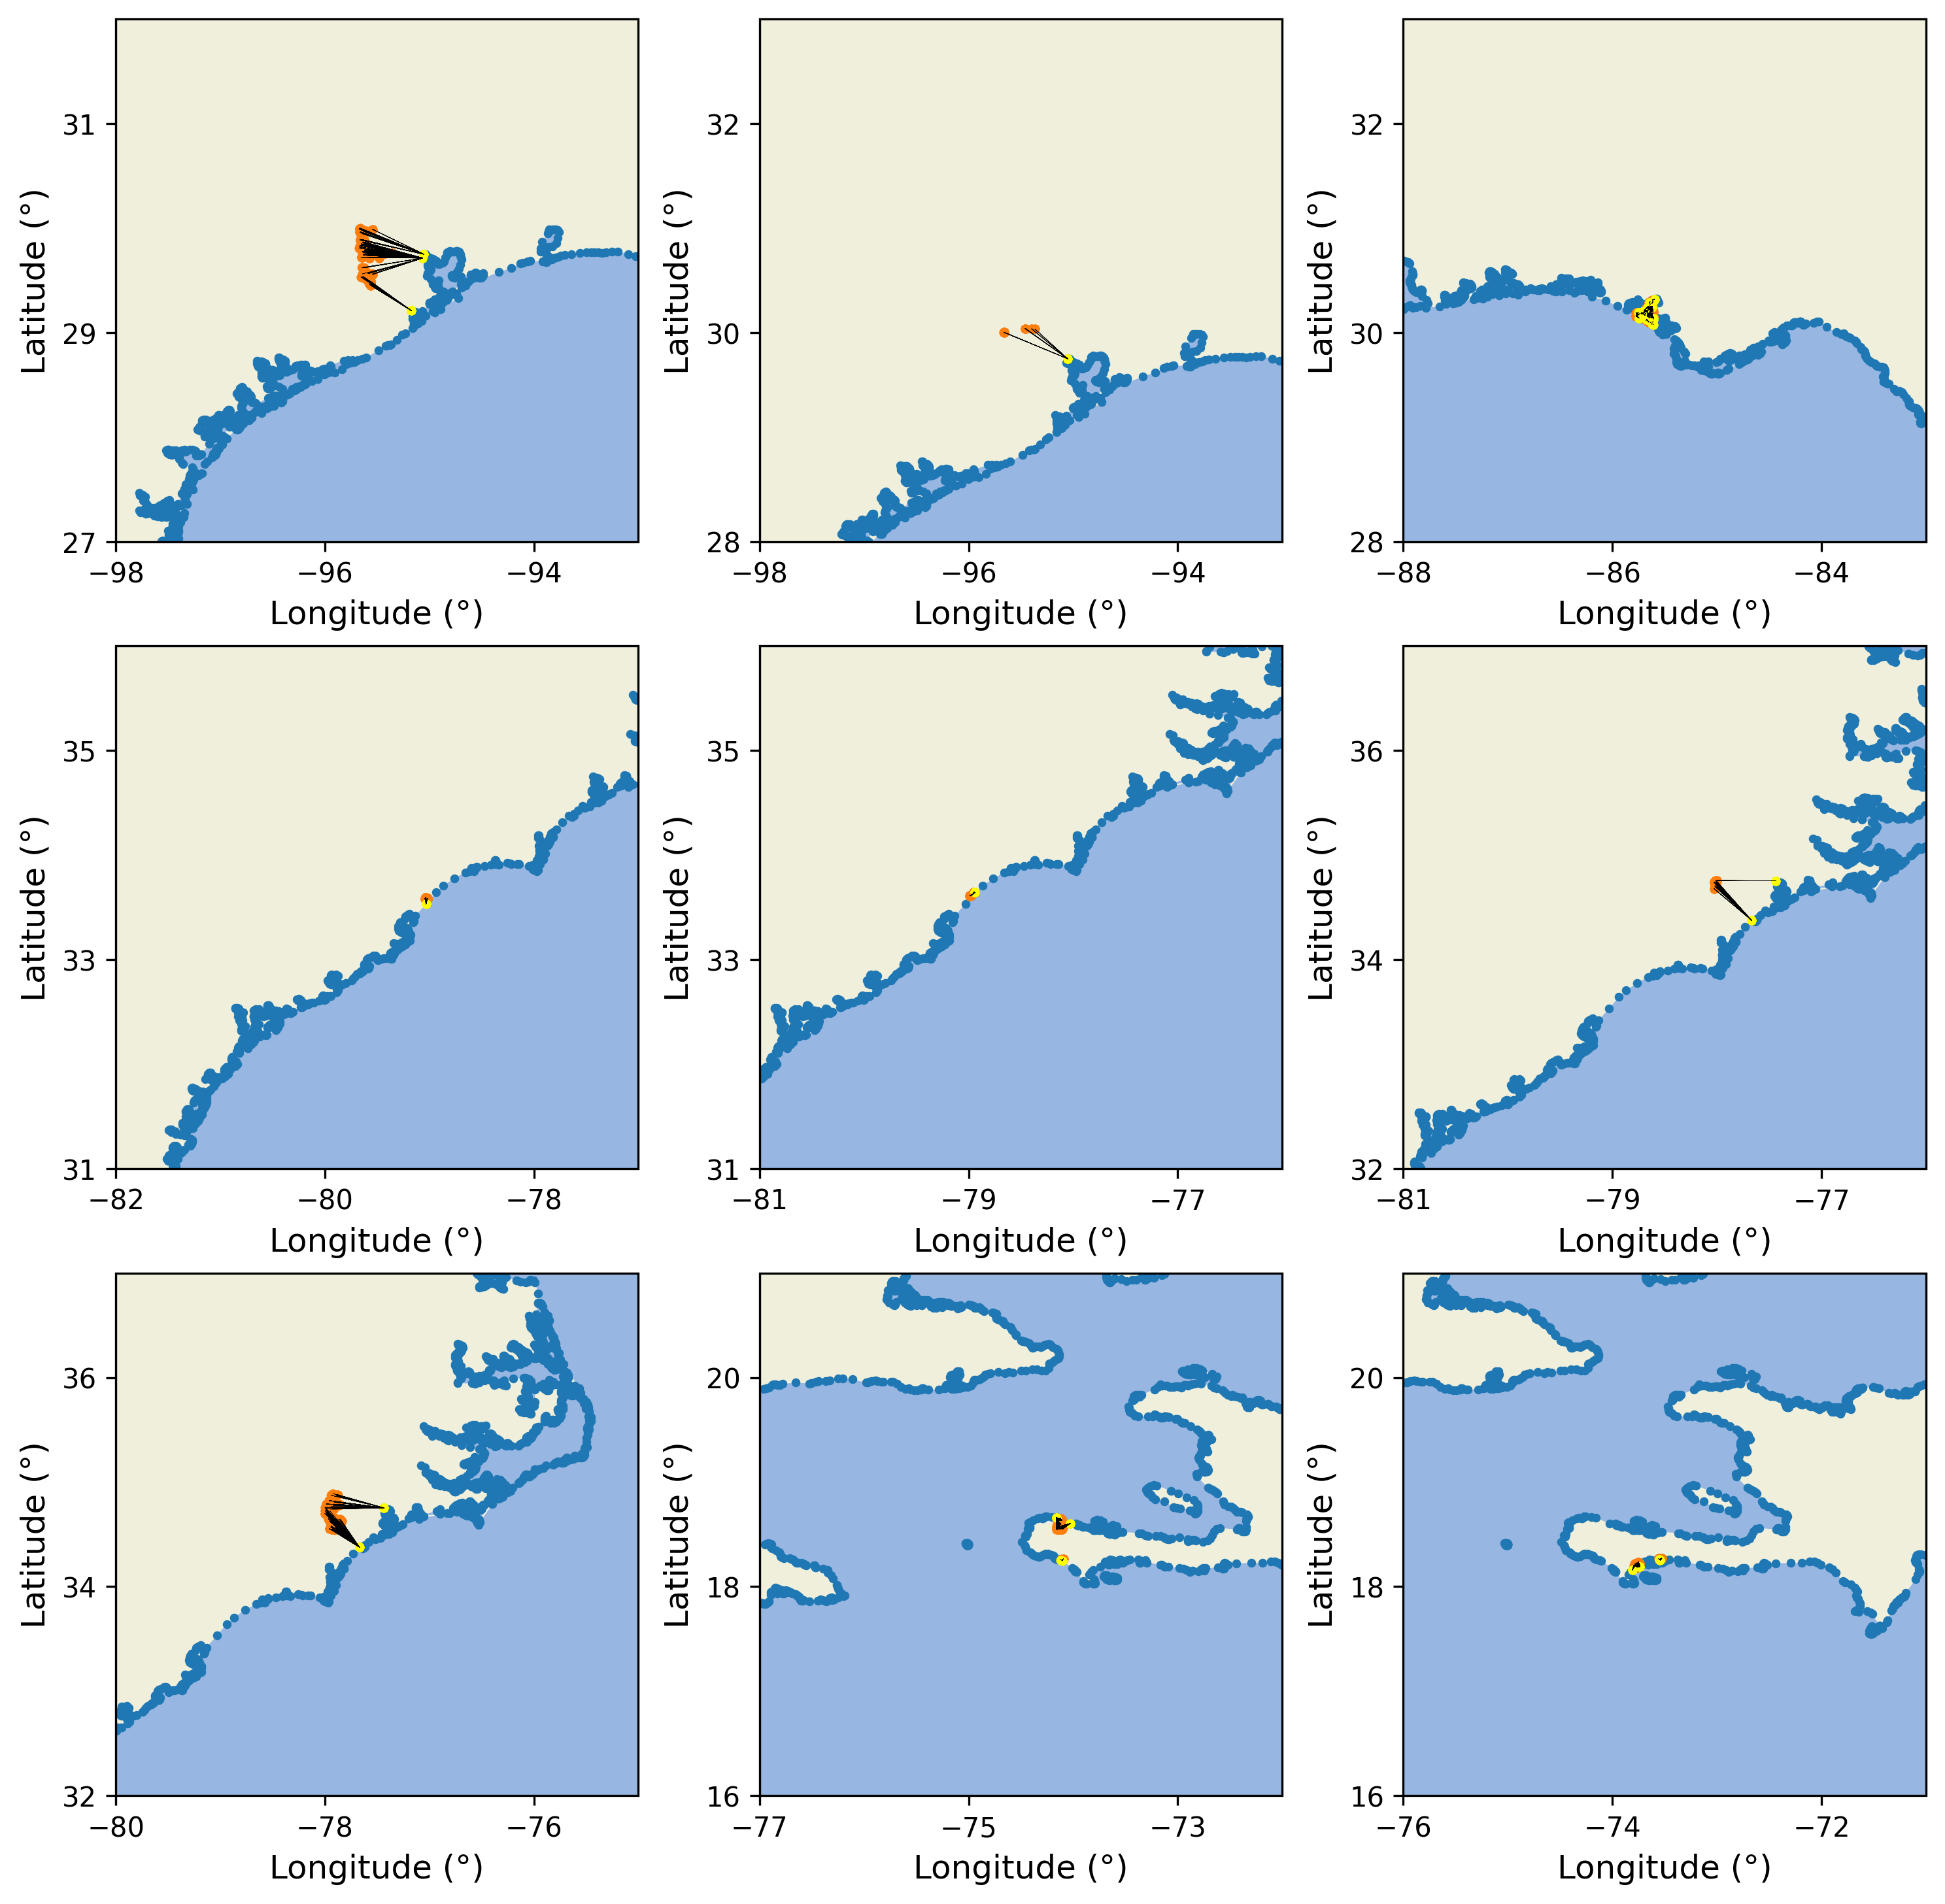

In [ ]:
# Find the closest point on the coastline to the building and return the distance
# NOTE! this cell is quite time consuming to run (dependding on the size of building location data and the coastline data)

# define the function that calculate Geodesic distance between two points
def geoddist(p1, p2):
  return Geodesic.WGS84.Inverse(p1[1], p1[0], p2[1], p2[0])['s12']

n_groups = len(building_groups) #
n_cols=3
n_rows = math.ceil(n_groups / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12),dpi=300,
                        subplot_kw={'projection': ccrs.PlateCarree()})

for i, (group_name, group_data) in enumerate(building_groups):
    west=int(np.floor(group_data['lon'].min()))
    east=int(np.ceil(group_data['lon'].max()))
    south=int(np.floor(group_data['lat'].min()))
    north=int(np.ceil(group_data['lat'].max()))

    dis_threshold=2 # assuming the building is not more than dis_threshold latitude and longitude away from the coast, please change it according to your case

    # chop the coastline data
    mask = (coast_points['coast_lon'] >= west-dis_threshold) & (coast_points['coast_lon'] <= east+dis_threshold) & \
          (coast_points['coast_lat'] >= south-dis_threshold) & (coast_points['coast_lat'] <= north+dis_threshold)
    points_within_range = coast_points[mask]

    # plot the buildings and the coastline data that been choped
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    ax.set_xlim(west-dis_threshold, east+dis_threshold)
    ax.set_ylim(south-dis_threshold, north+dis_threshold)
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))
    # Plot the coast points
    ax.scatter(points_within_range['coast_lon'], points_within_range['coast_lat'], s=5, transform=ccrs.PlateCarree())
    ax.scatter(group_data['lon'], group_data['lat'], s=5, transform=ccrs.PlateCarree())
    # Set x-label and y-label
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    # Set x-ticks and y-ticks
    xticks = np.arange(west-dis_threshold, east+dis_threshold, dis_threshold)
    yticks = np.arange(south-dis_threshold, north+dis_threshold, dis_threshold)

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    points_within_range = np.column_stack((points_within_range['coast_lon'], points_within_range['coast_lat']))
    buildings = np.column_stack((group_data['lon'], group_data['lat']))

    calculate_dis_to_coast=True  # the switch for whether or not to calculate the distance to the coast
    if calculate_dis_to_coast:
        closestp=np.zeros([len(buildings),2])# to store the closest point in the coast to a given building
        distance=np.zeros([len(buildings),1])# to store the building's distance to the coast
        coast_vp = vptree.VPTree(points_within_range, geoddist)  #build the lookup table

        for i in range(0,len(buildings)):
              data = coast_vp.get_nearest_neighbor(buildings[i,:])   # find buildings' closest point on the coast line and get the distance
              closestp[i,:]=data[1]
              distance[i]=data[0] #distance in unit of meter

        building_locs.loc[group_data.index, 'closestp_lon'] = closestp[:,0]  # store the calculated data into 'building_locs' dataframe
        building_locs.loc[group_data.index, 'closestp_lat'] = closestp[:,1]
        building_locs.loc[group_data.index, 'dis2coast'] = distance[:,0]

        ax.scatter(closestp[:,0], closestp[:,1], s=5, transform=ccrs.PlateCarree(),c='yellow')
        ax.plot([buildings[:,0],closestp[:,0]],[buildings[:,1],closestp[:,1]],'k',linewidth=0.1)
while i < n_cols*n_rows-1:
    fig.delaxes(axs.flatten()[i+1])
    i += 1
plt.show()

In [ ]:
#check the data
building_locs

,lat,lon,disaster_name,damage_class,closestp_lon,closestp_lat,dis2coast
0,30.207242,-85.673910,hurricane-michael,2,-85.699208,30.206529,2437.105901
1,30.207529,-85.674335,hurricane-michael,0,-85.699208,30.206529,2397.449175
2,30.207669,-85.673908,hurricane-michael,0,-85.699208,30.206529,2439.260601
3,30.207543,-85.673923,hurricane-michael,0,-85.699208,30.206529,2437.196135
4,30.207487,-85.673919,hurricane-michael,0,-85.699208,30.206529,2437.290753
...,...,...,...,...,...,...,...
23049,30.115500,-85.679114,hurricane-michael,0,-85.670888,30.122952,1144.882267
23050,30.115448,-85.678953,hurricane-michael,1,-85.670888,30.122952,1138.375342
23051,30.114085,-85.679504,hurricane-michael,1,-85.670888,30.122952,1286.714988
23052,30.113815,-85.679370,hurricane-michael,2,-85.670888,30.122952,1301.548837


In [ ]:
# The following code check whether DEM data has been downloaded
# If it is not, the DEM files can be downloaded from Land Processes Distributed Active Archive Center (LP DAAC) manually
# The link to download DEM files: https://e4ftl01.cr.usgs.gov/ASTT/ASTGTM.003/2000.03.01/
# If you have not download, please run this cell first to print the list of DEM files to download. 
# Then, put DEM files in a local floder and update the 'dem_zip_path' 
# and run the code, DEM files will ben extracted to 'extracted_path' (please change it according to your setting)

dem_tif_name_list=[]
dem_tif_path_list=[]
dem_tif_short_name_list=[]
for name, group in building_groups:
    lon_floor=int(np.floor(group['lon'].min()))
    lat_floor=int(np.floor(group['lat'].min()))
    # creating a string to download satelite data
    if lon_floor>0 and lat_floor>0:
      coordinate_str = f'N{lat_floor}E{abs(lon_floor):03}'
    if lon_floor<0 and lat_floor>0:
      coordinate_str = f'N{lat_floor}W{abs(lon_floor):03}'
    if lon_floor>0 and lat_floor<0:
      coordinate_str = f'S{lat_floor}E{abs(lon_floor):03}'
    if lon_floor<0 and lat_floor<0:
      coordinate_str = f'S{lat_floor}W{abs(lon_floor):03}'
    dem_zip_name=f'ASTGTMV003_{coordinate_str}.zip'
    # PLEASE MAUALLY DOWNLOAD THE DEM FILE SPECIFIED BY 'dem_zip_name' AND PUT IT INTO THE 'DEM_ZIP_PATH'
    dem_zip_path= f'/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/DEM_data/{dem_zip_name}' # path to store the downloaded data, please change it accordingly

    dem_tif_name=f'ASTGTMV003_{coordinate_str}_dem.tif'
    dem_tif_short_name=f'{coordinate_str}'
    extracted_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/terrain_data/DEM_data/DEM_extracted' # path to store the extracted data, please change it accordingly
    
    dem_tif_path=f'{extracted_path}/{dem_tif_name}'

    dem_tif_name_list.append(dem_tif_name)
    dem_tif_short_name_list.append(dem_tif_short_name)
    dem_tif_path_list.append(dem_tif_path)
    
    # Check if the .tif file already exists in the specified directory
    
    if os.path.isfile(dem_tif_path):
      continue
    else:
      if os.path.isfile(dem_zip_path):
        with zipfile.ZipFile(dem_zip_path, 'r') as zip_ref:
          zip_ref.extract(dem_tif_name, extracted_path)
      else:
        print('DEM file Not found, please download: ', dem_zip_name) 


In [ ]:
# This cell plot DEM files

# Set the number of columns and rows for the plot
num_cols = 3
num_rows = -(-len(dem_tif_path_list) // num_cols)

# Create a new figure with the appropriate number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,20),dpi=300)

# Iterate over the files and plot each one in a subplot
for i, file in enumerate(dem_tif_path_list):
    row, col = divmod(i, num_cols)
    ax = axs[row, col]
    with rio.open(file) as dem:
        dem_array = dem.read(1).astype('float64')
        handle=rio.plot.show(dem_array,transform=dem.transform,ax=ax,title=f'{dem_tif_short_name_list[i]}',cmap='gist_earth',vmin=0,vmax=np.percentile(dem_array,99)) #plot DEM map 

        im = handle.get_images()[0]
        cbar=fig.colorbar(im,ax=ax)
        cbar.set_label('Elevation (m)')
        ax.set_xlabel('Longitude(°)')
        ax.set_ylabel('Latitude(°)')

# Remove any unused subplots
for i in range(len(axs.flat)):
    if i >= len(dem_tif_path_list):
        fig.delaxes(axs.flat[i])
        
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# This cell define functions to get the height, slope and aspect for buildings

def lonlat2xy(lon,lat,dem): # This function convert longitude and latitude to x and y
  rows, cols = rio.transform.rowcol(dem.transform, lon, lat)
  return cols,rows

def get_height(df,dem): # get the height of the given location (given by lon and lat)
  coord_list = [(x,y) for x,y in zip(df['lon'], df['lat'])]
  data=[x for x in dem.sample(coord_list,1)]
  df['elevation'] =np.array(data)
  return df

# def get_height_v2(cols,rows,dem_array): # get the height of the given location (given by lon and lat)
#   x=np.arange(0,np.size(dem_array,1),1)
#   y=np.arange(0,np.size(dem_array,0),1)
#   f = interp2d(x,y,dem_array, kind='linear') #interploate
#   H_all=np.zeros([len(cols),1])
#   for i in range(0,len(cols)):  # do the interplotation one by one, otherwise the interp2d will sort the data
#      height=f(cols[i],rows[i])
#      H_all[i]=height
#   return H_all

def get_slope(cols,rows,slope):# get the slope of the given location (given by lon and lat)
  x=np.arange(0,np.size(slope,1),1)
  y=np.arange(0,np.size(slope,0),1)
  f = interp2d(x,y,slope, kind='linear') #interploate
  S_all=np.zeros([len(cols),1])  
  for i in range(0,len(cols)):   # do the interplotation one by one, otherwise the interp2d will sort the data
     s=f(cols[i],rows[i])
     S_all[i]=s
  return S_all

def get_aspect(cols,lat,aspect): # get the aspect of the given location (given by lon and lat)
  x=np.arange(0,np.size(aspect,1),1)
  y=np.arange(0,np.size(aspect,0),1)
  f = interp2d(x,y,aspect, kind='linear') #interploate
  #f = RegularGridInterpolator((x,y),aspect) #interploate
  A_all=np.zeros([len(cols),1])
  for i in range(0,len(cols)):  # do the interplotation one by one, otherwise the interp2d will sort the data
     a=f(cols[i],rows[i])
     A_all[i]=a
  return A_all


In [ ]:
# The following code call corresponding functions and calculate the elevation, slope and aspect for buildings 

esa_df=pd.DataFrame() # to store the calculated elevation, slope and aspect
for i, (group_name,group_data) in enumerate(building_groups):
    with rio.open(dem_tif_path_list[i]) as dem:
        dem_array = dem.read(1).astype('float64')
        dem4slope  = rd.rdarray(dem_array, no_data=-9999) 
        dem4slope.geotransform = [0,1,0,0,0,1,0] # defining the geotransfrom, the top left corner is (0,0), width and heigth of a pixel is 1
        slope = rd.TerrainAttribute(dem4slope, attrib='slope_riserun',zscale=1) #calculate slope
        aspect = rd.TerrainAttribute(dem4slope, attrib='aspect') # calculate aspect

        temp_df=group_data
        temp_df=get_height(temp_df,dem) #calculate height
        cols,rows=lonlat2xy(temp_df['lon'].values,temp_df['lat'].values,dem)
        temp_df['slope']=get_slope(cols,rows,slope) #calculate slope
        temp_df['aspect']=get_aspect(cols,rows,aspect)#calculate aspect
        esa_df=pd.concat([esa_df,temp_df],ignore_index = False)  

esa_df=esa_df.sort_index()
esa_df


<ipython-input-47-bb52a3844492>:26: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(x,y,slope, kind='linear') #interploate
<ipython-input-47-bb52a3844492>:29: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids us

,lat,lon,disaster_name,damage_class,closestp_lon,closestp_lat,dis2coast,elevation,slope,aspect
0,30.207242,-85.673910,hurricane-michael,2,-85.699208,30.206529,2437.105901,6,1.075291,215.537674
1,30.207529,-85.674335,hurricane-michael,0,-85.699208,30.206529,2397.449175,5,1.380670,185.194427
2,30.207669,-85.673908,hurricane-michael,0,-85.699208,30.206529,2439.260601,7,0.883883,98.130104
3,30.207543,-85.673923,hurricane-michael,0,-85.699208,30.206529,2437.196135,7,0.395285,161.565048
4,30.207487,-85.673919,hurricane-michael,0,-85.699208,30.206529,2437.290753,7,0.395285,161.565048
...,...,...,...,...,...,...,...,...,...,...
23049,30.115500,-85.679114,hurricane-michael,0,-85.670888,30.122952,1144.882267,8,2.698379,166.607498
23050,30.115448,-85.678953,hurricane-michael,1,-85.670888,30.122952,1138.375342,8,2.136001,159.443954
23051,30.114085,-85.679504,hurricane-michael,1,-85.670888,30.122952,1286.714988,8,1.250000,216.869904
23052,30.113815,-85.679370,hurricane-michael,2,-85.670888,30.122952,1301.548837,6,0.176777,315.000000


In [ ]:
# Explore the data to a local path

Terrian_EFs=pd.DataFrame({'xbd_observation_lat':esa_df['lat'],'xbd_observation_lon':esa_df['lon'],
                           'elevation':esa_df['elevation'],'slope':esa_df['slope'],'aspect':esa_df['aspect'],
                           'dis2coast':esa_df['dis2coast'],'disaster_name':esa_df['disaster_name'],'damage_class':esa_df['damage_class']})

# path to store Terrain_EFs
path_Terrain_EFs='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/Terrian_EFs.pkl'

Terrian_EFs.to_pickle(path_Terrain_EFs) # store the dataframe
# read the stored data for test
with open(path_Terrain_EFs, 'rb') as f:
    Terrian_EFs_test = pickle.load(f)
    
Terrian_EFs_test

,xbd_observation_lat,xbd_observation_lon,elevation,slope,aspect,dis2coast,disaster_name,damage_class
0,30.207242,-85.673910,6,1.075291,215.537674,2437.105901,hurricane-michael,2
1,30.207529,-85.674335,5,1.380670,185.194427,2397.449175,hurricane-michael,0
2,30.207669,-85.673908,7,0.883883,98.130104,2439.260601,hurricane-michael,0
3,30.207543,-85.673923,7,0.395285,161.565048,2437.196135,hurricane-michael,0
4,30.207487,-85.673919,7,0.395285,161.565048,2437.290753,hurricane-michael,0
...,...,...,...,...,...,...,...,...
23049,30.115500,-85.679114,8,2.698379,166.607498,1144.882267,hurricane-michael,0
23050,30.115448,-85.678953,8,2.136001,159.443954,1138.375342,hurricane-michael,1
23051,30.114085,-85.679504,8,1.250000,216.869904,1286.714988,hurricane-michael,1
23052,30.113815,-85.679370,6,0.176777,315.000000,1301.548837,hurricane-michael,2


In [ ]:
# plot dem map and building locations 
# Set the number of columns and rows for the plot
num_cols = 3
num_rows = -(-len(dem_tif_path_list) // num_cols)

# Create a new figure with the appropriate number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,20),dpi=300)

for i, (group_name,group_data) in enumerate(building_groups):
    with rio.open(dem_tif_path_list[i]) as dem:
        dem_array = dem.read(1).astype('float64')
        row, col = divmod(i, num_cols)
        ax = axs[row, col]
        handle=rio.plot.show(dem_array,transform=dem.transform,ax=ax,title=f'{dem_tif_short_name_list[i]}',cmap='gist_earth',vmin=0,vmax=np.percentile(dem_array,99)) #plot DEM map 
        temp_df=group_data
        gdf=gpd.GeoDataFrame(temp_df,geometry=gpd.points_from_xy(temp_df.lon,temp_df.lat), crs=dem.crs)
        gdf.plot(ax=handle,color='red') #plot location of buildings
        im = handle.get_images()[0]
        cbar=fig.colorbar(im,ax=ax)
        cbar.set_label('Elevation (m)')
        ax.set_xlabel('Longitude(°)')
        ax.set_ylabel('Latitude(°)')

# Remove any unused subplots
for i in range(len(axs.flat)):
    if i >= len(dem_tif_path_list):
        fig.delaxes(axs.flat[i])
        
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# plot the slope and building locations 
# Set the number of columns and rows for the plot
num_cols = 3
num_rows = -(-len(dem_tif_path_list) // num_cols)

# Create a new figure with the appropriate number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,20),dpi=200)

for i, (group_name,group_data) in enumerate(building_groups):
    with rio.open(dem_tif_path_list[i]) as dem:
        dem_array = dem.read(1).astype('float64')
        row, col = divmod(i, num_cols)
        ax = axs[row, col]
        dem4slope  = rd.rdarray(dem_array, no_data=-9999) 
        dem4slope.geotransform = [0,1,0,0,0,1,0] # defining the geotransfrom, the top left corner is (0,0), width and heigth of a pixel is 1
        slope = rd.TerrainAttribute(dem4slope, attrib='slope_riserun') #calculate slope
        handle=rio.plot.show(slope,transform=dem.transform,ax=ax,title=f'{dem_tif_short_name_list[i]}',cmap='PuBu',vmin=0,vmax=np.percentile(slope,95)) #plot DEM map 
        temp_df=group_data
        gdf=gpd.GeoDataFrame(temp_df,geometry=gpd.points_from_xy(temp_df.lon,temp_df.lat), crs=dem.crs)
        gdf.plot(ax=handle,color='red') #plot location of buildings
        im = handle.get_images()[0]
        cbar=fig.colorbar(im,ax=ax)
        cbar.set_label('Slope (%)')
        ax.set_xlabel('Longitude(°)')
        ax.set_ylabel('Latitude(°)')

# Remove any unused subplots
for i in range(len(axs.flat)):
    if i >= len(dem_tif_path_list):
        fig.delaxes(axs.flat[i])
        
# Show the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [52]:
# plot the aspect and building locations 
# Set the number of columns and rows for the plot
num_cols = 3
num_rows = -(-len(dem_tif_path_list) // num_cols)

# Create a new figure with the appropriate number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,20),dpi=200)

for i, (group_name,group_data) in enumerate(building_groups):
    with rio.open(dem_tif_path_list[i]) as dem:
        dem_array = dem.read(1).astype('float64')
        row, col = divmod(i, num_cols)
        ax = axs[row, col]
        dem4slope  = rd.rdarray(dem_array, no_data=-9999) 
        dem4slope.geotransform = [0,1,0,0,0,1,0] # defining the geotransfrom, the top left corner is (0,0), width and heigth of a pixel is 1
        #slope = rd.TerrainAttribute(dem4slope, attrib='slope_riserun') #calculate slope
        aspect = rd.TerrainAttribute(dem4slope, attrib='aspect') # calculate aspect

        handle=rio.plot.show(aspect,transform=dem.transform,ax=ax,title=f'{dem_tif_short_name_list[i]}',cmap='twilight_shifted',vmin=0,vmax=np.percentile(aspect,95)) #plot DEM map 

        temp_df=group_data
        gdf=gpd.GeoDataFrame(temp_df,geometry=gpd.points_from_xy(temp_df.lon,temp_df.lat), crs=dem.crs)
        gdf.plot(ax=handle,color='red') #plot location of buildings
        im = handle.get_images()[0]
        cbar=fig.colorbar(im,ax=ax)
        cbar.set_label('Aspect (°)')
        ax.set_xlabel('Longitude(°)')
        ax.set_ylabel('Latitude(°)')

# Remove any unused subplots
for i in range(len(axs.flat)):
    if i >= len(dem_tif_path_list):
        fig.delaxes(axs.flat[i])
        
# Show the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.